In [5]:
from collections import defaultdict
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite
from dwave.system import DWaveSampler, EmbeddingComposite
from dimod import BinaryQuadraticModel
import numpy as np
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("agg")
%matplotlib inline

from __future__ import annotations
import numpy as np
from typing import Sequence, Tuple, Dict
import time

QUBO MODELING
-------------
Minimise  
$$\min_{x_i  \in \{ 0, 1\}^5 } H = \min_{x_i  \in \{ 0, 1\}^5 } \big( Σ_t  [ (C_i - 2γ D_t P_{i,t} + γ P_{i,t}² + δ_i(1-A_{i,t}) - ε_i A_{i,t}) x_{t,i}
                   +  Σ_{i<j} 2γ P_{i,t} P_{j,t} x_{t,i} x_{t,j} ] \big)$$

- Binary x_{t,i} indicates whether source $i$ is ON at step $t$.
- Fuel (index 4) has no availability term ($A=1$ by definition).

In [16]:
class QURRENT:
    def __init__(self, 
        T: int,
        costs: Sequence[float],
        P: np.ndarray,
        demand: Sequence[float],
        avail: np.ndarray,
        delta: Sequence[float],
        gamma: float,
        epsilon: Sequence[float]) -> None:
    
        self.qubo = None
        self.Q = {}
        self.Qmat = np.zeros((5 * T, 5 * T), dtype=float)
        self.bqm = BinaryQuadraticModel.from_qubo(self.Q)
        self.sampler = None
        self.response = None
        self.solution = None
        self.energy = None
        self.num_reads = []
        self.elapsed_time = 0.0
        self.print = print

        # INPUTS
        self.T = T
        self.costs = costs
        self.P = P
        self.demand = demand
        self.avail = avail
        self.delta = delta
        self.gamma = gamma
        self.epsilon = epsilon


        """
        GOAL:
        Build a QUBO matrix for multi-source (Solar, Wind, WTE, Hydro, Fuel) grid-scheduling.

        SUMMARY
        -------
        Minimise  H = Σ_t  [ (C_i - 2γ D_t P_{i,t} + γ P_{i,t}² + δ_i(1-A_{i,t}) - ε_i A_{i,t}) x_{t,i}
                            +  Σ_{i<j} 2γ P_{i,t} P_{j,t} x_{t,i} x_{t,j} ]

        Binary x_{t,i} indicates whether source *i* is ON at step *t*.
        Fuel (index 4) has no availability term (A=1 by definition).

        """

    # --------------------------------------------------------------------------- #
    #   USER HELPER: THIS IS TO HELP THE USER DEFINE THE INPUT PARAMS
    # --------------------------------------------------------------------------- #
    def check_input(self):
        if len(self.costs) != 5:
            raise ValueError("costs must have length 5 (solar, wind, wte, hydro, fuel)")
        if self.P.shape != (self.T, 5):
            raise ValueError(f"P must be shape (T,5); got {self.P.shape}")
        if len(self.demand) != self.T:
            raise ValueError("demand must have length T")
        if self.avail.shape != (self.T, 4):
            raise ValueError(f"avail must be shape (T,4) for the 4 renewables; got {self.avail.shape}")
        if len(self.delta) != 4 or len(self.epsilon) != 4:
            raise ValueError("delta and epsilon must have length 4 (for the 4 renewable sources)")
        else:
            print("ALL IS GOOD!")


    # --------------------------------------------------------------------------- #
    #   UTILITY: FLATTEN
    # --------------------------------------------------------------------------- #
    def flatten_index(self, t: int, i: int) -> int:
        """Map (time-step, source) -> flat index in [0, 5T)."""
        return 5 * t + i

    # --------------------------------------------------------------------------- #
    #   BUILD QUBO MATRIX
    # --------------------------------------------------------------------------- #
    def build_mat(self) -> np.ndarray:
        """
        Parameters
        ----------
        T        : horizon length
        costs    : [C_solar, C_wind, C_wte, C_hydro, C_fuel]
        P        : ndarray shape (T,5) of available power for each source at each t
        demand   : list/array length T of demand D_t
        gamma    : demand-mismatch penalty (>0)
        delta    : length-4 list of unavailability penalties for the four renewables
        epsilon  : length-4 list of rewards for using available renewables
        avail    : ndarray shape (T,4) of availability flags (0/1) for the renewables

        Returns
        -------
        Qmat  : (5T × 5T) numpy array (symmetric)
        """

        for t in range(T):
            Dt = self.demand[t]
            # DIAGONAL TERMS
            for i in range(5):
                k = self.flatten_index(t, i)
                Ci = costs[i]
                Pi = P[t, i]
                diag = Ci - 2 * self.gamma * Dt * Pi + self.gamma * Pi ** 2
                if i < 4:  # renewable, add availability modifiers
                    Ai = self.avail[t, i]
                    diag += self.delta[i] * (1 - Ai) - self.epsilon[i] * Ai
                self.Qmat[k, k] = diag

            # OFF-DIAGONAL TERMS
            for i in range(5):
                for j in range(i + 1, 5):
                    k1, k2 = self.flatten_index(t, i), self.flatten_index(t, j)
                    self.Qmat[k1, k2] = self.Qmat[k2, k1] = self.gamma * self.P[t, i] * self.P[t, j]

    # --------------------------------------------------------------------------- #
    #   FORMAT QUBO MATRIX
    # --------------------------------------------------------------------------- #
    def build_Q(self) -> Dict[Tuple[int, int], float]:
        threshold: float = 1e-12
        """
        Convert dense Qmat to the sparse dict format.
        Entries with |value| < `threshold` are dropped.
        """
        n = self.Qmat.shape[0]
        for i in range(n):
            for j in range(i, n):
                val = self.Qmat[i, j]
                if abs(val) > threshold:
                    self.Q[(i, j)] = float(val)

    # --------------------------------------------------------------------------- #
    #   SOLVE USING QUNATUM ANNEALING
    # --------------------------------------------------------------------------- #
    def solveQA(self, num_reads):

        # LABLE
        label = "ENERGY OPTIMIZATION"
        
        t0 = time.time()
        self.sampler = EmbeddingComposite(DWaveSampler())
        t1 = time.time()
        elapsed_time = t1 - t0
        self.elapsed_time = elapsed_time
        
        sampler_name = self.sampler.properties['child_properties']['chip_id']
        self.response = self.sampler.sample(self.bqm, num_reads, label=label)
        
        # GET RESULT
        self.response = self.sampler.sample(self.bqm, num_reads)
        self.solution = list(self.response.first.sample.values())
        self.energy = self.response.first.energy
        
        # PRINT RESULTS
        if (self.print):
            print("NREADS: ", num_reads)
            print("CONFIG:", self.solution)
            print("ENERGY:", self.energy)
            print(f"TIME[s]:  {elapsed_time:.6f}")

    # --------------------------------------------------------------------------- #
    #   ASSEMBLE QUBO MODEL
    # --------------------------------------------------------------------------- #
    def assemble(self):
        self.check_input()
        self.build_mat()
        self.build_Q()
        return self.Q

In [55]:
def QPUJob(Q, num_reads, label, solver_name=None):
    """
    Submit a QUBO problem to a D-Wave QPU solver.

    Args:
        Q (dict): QUBO dictionary.
        num_reads (int): Number of reads (samples) to perform.
        label (str): Job label for tracking.
        solver_name (str, optional): Specific D-Wave solver name. If None, use default.
    """

    # Initialize BQM
    bqm = BinaryQuadraticModel.from_qubo(Q)

    print("Initializing QPU solver...")

    # Initialize the sampler
    if solver_name:
        sampler = EmbeddingComposite(DWaveSampler(solver=solver_name))
    else:
        sampler = EmbeddingComposite(DWaveSampler())

    # Start timing
    start_time = time.time()
    print("Submitting job to the QPU...")

    # Submit job
    response = sampler.sample(bqm, num_reads=num_reads, label=label)
    end_time = time.time()

    # Extract best result
    solution = list(response.first.sample.values())
    energy = response.first.energy

    # Compute timing
    total_time = end_time - start_time

    # Get solver details
    try:
        sampler_properties = sampler.child.properties
        solver_used = sampler_properties.get('chip_id', 'Unknown')
    except Exception:
        solver_used = 'Unknown'

    # === PRINT RESULTS ===
    print("\n=== QPU Job Completed ===")
    print(f"Label: {label}")
    print(f"Solver Used: {solver_used}")
    print(f"Total Time (seconds): {total_time:.4f}")
    print(f"Number of Reads: {num_reads}")

    print("\n=== Detailed Response ===")
    print(f"Best Configuration: {solution}")
    print(f"Best Energy: {energy}")
    print(f"All Samples: {response}")
    print(f"Number of Solutions: {len(response)}")
    print(f"Occurrences of Best Solution: {response.first.num_occurrences}")

    return response



def ClassicalJob(Q, num_reads, label):
    # Initialize the classical solver
    print("Initializing classical solver (Simulated Annealing)...")
    bqm = BinaryQuadraticModel.from_qubo(Q)
    sampler = SimulatedAnnealingSampler()
    
    # Start timing the sampling process
    start_time = time.time()
    print("Submitting job to the classical solver...")
    
    # Submit the job
    response = sampler.sample(bqm, num_reads=num_reads)
    end_time = time.time()
    
    # Get the best result
    solution = list(response.first.sample.values())
    energy = response.first.energy
    
    # Print timing information
    total_time = end_time - start_time
    print("\n=== Classical Job Completed ===")
    print(f"Label: {label}")
    print(f"Total Time (seconds): {total_time:.4f}")
    print(f"Number of Reads: {num_reads}")
    
    # Print response details
    print("\n=== Detailed Response ===")
    print(f"Best configuration: {solution}")
    print(f"Best energy: {energy}")
    print(f"All samples: {response}")
    print(f"Number of solutions: {len(response)}")
    print(f"Occurrences of best solution: {response.first.num_occurrences}")
    
    return response

# EXAMPLE: SMALL PROBLEM

In [57]:
T = 3

# Cost per unit (relative numbers; lower = better)
costs = [1.0, 2.5, 3.5, 5.0, 10.0]  # Solar, Wind, WTE, Hydro, Fuel

# Power available from each source at each hour (kW)
P = np.array([
    [60, 10, 20, 5, 100],    # 9:00 AM
    [70, 5, 20, 5, 100],     # 10:00 AM
    [80, 7, 20, 5, 100],     # 11:00 AM
], dtype=float)

# Demand (kW)
demand = [80, 85, 90]   # grid load at each hour

# Availability (binary 0/1 for renewable sources only: Solar, Wind, WTE, Hydro)
avail = np.array([
    [1, 1, 1, 1],  # all renewables OK at 9:00
    [1, 0, 1, 1],  # wind unavailable at 10:00
    [1, 1, 1, 1],  # all back at 11:00
])

# Penalty for using unavailable renewable sources (delta)
delta = [100, 100, 30, 10]  # strong penalty for solar/wind unavailability

# Reward for using available renewable sources (epsilon)
epsilon = [20, 15, 10, 5]

# Penalty for mismatch between demand and supplied power (gamma)
gamma = 200.0

In [59]:
# SOLUTION ENCODING
Energy_sources = ['Solar', 'Wind', 'Waste-to-Energy', 'Hydro', 'Fuel']

# MODEL ASSEMBLY
model = QURRENT(T, costs, P, demand, avail, delta, gamma, epsilon)
Q = model.assemble()

#QPUJob(Q, 200, "OPT")
QPUJob(Q, 2000, "3H", "Advantage_system7.1")

ALL IS GOOD!
Initializing QPU solver...
Submitting job to the QPU...

=== QPU Job Completed ===
Label: 3H
Solver Used: Advantage_system7.1
Total Time (seconds): 0.0937
Number of Reads: 2000

=== Detailed Response ===
Best Configuration: [np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0)]
Best Energy: -5680199.0
All Samples:      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14     energy num_oc. ...
0    1  1  1  1  0  1  1  1  1  0  1  1  1  1  0 -5680199.0      87 ...
439  1  1  1  1  0  1  1  1  1  0  1  1  1  1  0 -5680199.0       1 ...
1    1  1  1  0  0  1  1  1  1  0  1  1  1  1  0 -5615199.0      44 ...
2    1  1  1  1  0  1  1  1  1  0  1  1  1  0  0 -5612199.0      65 ...
3    1  1  1  1  0  1  0  1  1  0  1  1  1  1  0 -5610301.5      36 ...
4    1  1  1  1  0  1  1  1  0  0  1  1  1  1  0 -5610199.0      43 ...
5    1  1  1  1  0  1  1  1  1  0  1  0  

SampleSet(rec.array([([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], -5680199. , 87, 0.        ),
           ([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], -5615199. , 44, 0.        ),
           ([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0], -5612199. , 65, 0.        ),
           ([1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0], -5610301.5, 36, 0.        ),
           ([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], -5610199. , 43, 0.        ),
           ([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0], -5584986.5, 26, 0.        ),
           ([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], -5552170. , 62, 0.        ),
           ([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], -5550186.5, 12, 0.        ),
           ([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0], -5547199. , 26, 0.        ),
           ([1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0], -5545301.5, 25, 0.        ),
           ([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], -5545199. , 23, 0.        ),
           ([1, 1, 1, 

# EXAMPLE: 10 HOURS SCHEDULING

In [151]:
T = 10  # 10 hours

# Cost per unit energy for each source (lower cost is better)
costs = [1.0, 2.5, 3.5, 5.0, 10.0]  # Solar, Wind, WTE, Hydro, Fuel

# Power available from each source at each hour (rows = hours, columns = sources)
P = np.array([
    [50,  8, 18,  5, 100],   # 1
    [55, 10, 20,  5, 100],   # 2
    [60, 12, 20,  5, 100],   # 3
    [65,  5, 18,  5, 100],   # 4 (wind drops)
    [70,  6, 20,  5, 100],   # 5
    [75,  8, 20,  5, 100],   # 6
    [80,  9, 22,  5, 100],   # 7
    [85, 11, 20,  5, 100],   # 8
    [90,  7, 20,  5, 100],   # 9
    [95,  8, 18,  5, 100],   # 10
], dtype=float)

# Demand (kW) for each hour
demand = [70, 75, 80, 85, 90, 95, 100, 100, 105, 110]

# Availability (only for renewables: Solar, Wind, WTE, Hydro) binary 0/1
avail = np.array([
    [1, 1, 1, 1],  # 1
    [1, 1, 1, 1],  # 2
    [1, 0, 1, 1],  # 3 (wind down)
    [1, 0, 1, 1],  # 4
    [1, 1, 1, 1],  # 5
    [1, 1, 1, 1],  # 6
    [1, 1, 1, 1],  # 7
    [1, 0, 1, 1],  # 8
    [1, 0, 1, 1],  # 9
    [1, 1, 1, 1],  # 10
], dtype=int)

# Penalty for using an unavailable renewable
delta = [100, 100, 30, 10]  # [Solar, Wind, WTE, Hydro]

# Incentive to use available renewables
epsilon = [20, 15, 10, 5]

# Penalty for mismatch between total supply and demand
gamma = 200.0


In [160]:
# SOLUTION ENCODING
Energy_sources = ['Solar', 'Wind', 'Waste-to-Energy', 'Hydro', 'Fuel']

# MODEL ASSEMBLY
model = QURRENT(T, costs, P, demand, avail, delta, gamma, epsilon)
Q = model.assemble()
#ClassicalJob(Q, 4000, "OPT")
#QPUJob(Q, 200, "OPT")
QPUJob(Q, 6000, "10H", "Advantage_system7.1")

ALL IS GOOD!
Initializing QPU solver...
Submitting job to the QPU...

=== QPU Job Completed ===
Label: 10H
Solver Used: Advantage_system7.1
Total Time (seconds): 0.1968
Number of Reads: 6000

=== Detailed Response ===
Best Configuration: [np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0)]
Best Energy: -21710920.0
All Samples:       0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 49      energy num_oc. ...
0     1  1  1  0  0  1  1  1  0  0  1  1  1  

SampleSet(rec.array([([1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], -21710920. , 1, 0.  ),
           ([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1], -21672503.5, 1, 0.  ),
           ([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1], -21669078.5, 1, 0.  ),
           ...,
           ([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0], -19025854.5, 1, 0.02),
           ([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0], -20277217. , 1, 0.04),
           ([0, 0, 0, 0, 1, 0, 1, 1, 0,

# EXTRACT RESULTS

In [163]:
solution = results.first.sample
energy = results.first.energy
n_vars = len(solution)
flat_sol = np.array([ solution[i] for i in range(n_vars) ], dtype=int)

In [ ]:
sol = np.array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1])

energy_sources = ['Solar', 'Wind', 'Waste-to-Energy', 'Hydro', 'Fuel']


array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1])

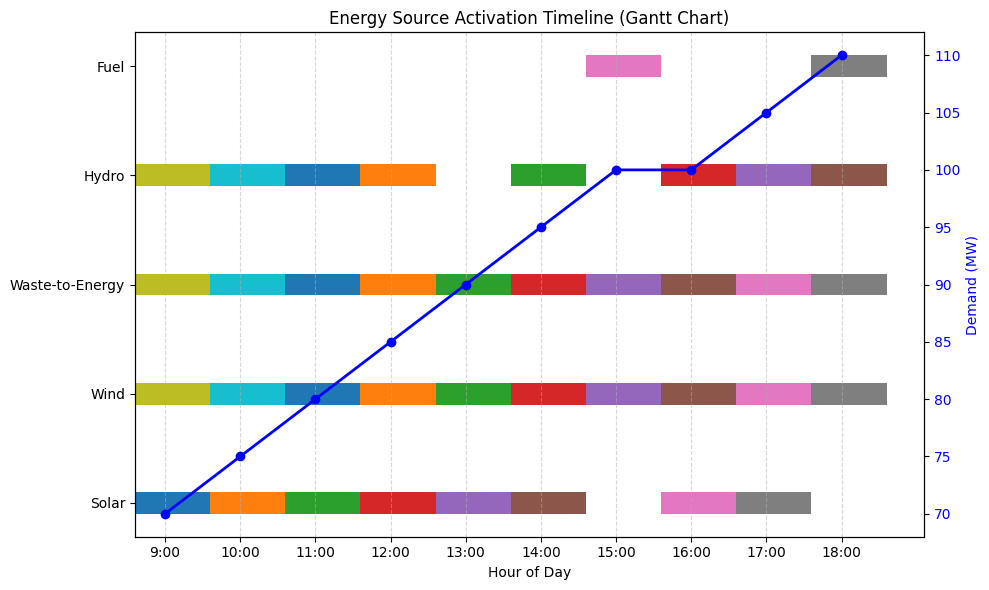

In [ ]:
# Example inputs
energy_sources = ['Solar', 'Wind', 'Waste-to-Energy', 'Hydro', 'Fuel']
T = 10  # Number of time steps
times = np.arange(9, 9 + T)  # Hours: 9, 10, 11, ...
solution = flat_sol

# Reshape solution into (T, n_sources)
n_sources = len(energy_sources)
solution_matrix = np.array(solution).reshape((T, n_sources))

# Plot Gantt Chart with Twin Axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Gantt Chart on the left axis
for i, source in enumerate(energy_sources):
    active = np.where(solution_matrix[:, i] == 1)[0]
    for t in active:
        ax1.barh(y=source, width=1, left=times[t] - 0.4, height=0.2)

ax1.set_xlabel('Hour of Day')
ax1.set_title('Energy Source Activation Timeline (Gantt Chart)')
ax1.set_xticks(times)
ax1.set_xticklabels([f'{h}:00' for h in times])
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# Create a twin axis to plot demand on the right
ax2 = ax1.twinx()
ax2.plot(times, demand, color='blue', marker='o', label='Demand (MW)', linestyle='-', linewidth=2)
ax2.set_ylabel('Demand (MW)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot
fig.tight_layout()
plt.show()


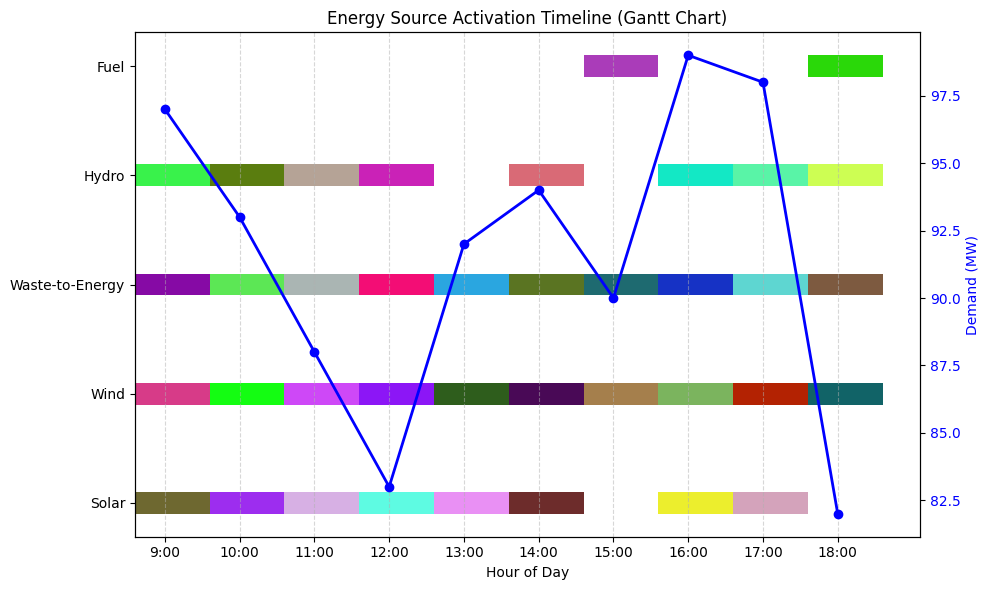

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Example inputs
energy_sources = ['Solar', 'Wind', 'Waste-to-Energy', 'Hydro', 'Fuel']
T = 10  # Number of time steps
times = np.arange(9, 9 + T)  # Hours: 9, 10, 11, ...
solution = flat_sol

# Reshape solution into (T, n_sources)
n_sources = len(energy_sources)
solution_matrix = np.array(solution).reshape((T, n_sources))

# Plot Gantt Chart with Twin Axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Gantt Chart on the left axis
for i, source in enumerate(energy_sources):
    active = np.where(solution_matrix[:, i] == 1)[0]
    for t in active:
        ax1.barh(y=source, width=1, left=times[t] - 0.4, height=0.2, color=np.random.rand(3,))

ax1.set_xlabel('Hour of Day')
ax1.set_title('Energy Source Activation Timeline (Gantt Chart)')
ax1.set_xticks(times)
ax1.set_xticklabels([f'{h}:00' for h in times])
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# Create a twin axis to plot demand on the right
ax2 = ax1.twinx()
ax2.plot(times, demand, color='blue', marker='o', label='Demand (MW)', linestyle='-', linewidth=2)
ax2.set_ylabel('Demand (MW)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Show the plot
fig.tight_layout()
plt.show()

In [148]:
# Plot Gantt Chart on the left axis
for i, source in enumerate(energy_sources):
    active = np.where(solution_matrix[:, i] == 1)[0]
    for t in active:
        ax1.barh(y=source, width=1, left=times[t] - 0.4, height=0.2, color=np.random.rand(3,))
        print(source)

Solar
Solar
Solar
Solar
Solar
Solar
Solar
Solar
Wind
Wind
Wind
Wind
Wind
Wind
Wind
Wind
Wind
Wind
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Waste-to-Energy
Hydro
Hydro
Hydro
Hydro
Hydro
Hydro
Hydro
Hydro
Fuel
Fuel


# EXAMPLE: 24 HOURS SCHEDULING

In [63]:
T = 24  # 24 hours

# Cost per unit (lower = better)
costs = [1.0, 2.5, 3.5, 5.0, 10.0]  # Solar, Wind, WTE, Hydro, Fuel

# Power available (Solar strongest mid-day, Wind fluctuates, WTE and Hydro steady)
P = np.array([
    [0,  8, 20, 5, 100],   # 00:00
    [0,  7, 20, 5, 100],   # 01:00
    [0,  6, 20, 5, 100],   # 02:00
    [0,  7, 20, 5, 100],   # 03:00
    [5,  9, 20, 5, 100],   # 04:00
    [10, 10, 20, 5, 100],  # 05:00
    [20, 12, 20, 5, 100],  # 06:00
    [40, 14, 20, 5, 100],  # 07:00
    [60, 16, 20, 5, 100],  # 08:00
    [80, 12, 20, 5, 100],  # 09:00
    [90, 10, 20, 5, 100],  # 10:00
    [100, 8, 20, 5, 100],  # 11:00
    [95, 7, 20, 5, 100],   # 12:00
    [90, 6, 20, 5, 100],   # 13:00
    [85, 8, 20, 5, 100],   # 14:00
    [70, 10, 20, 5, 100],  # 15:00
    [50, 12, 20, 5, 100],  # 16:00
    [30, 10, 20, 5, 100],  # 17:00
    [10, 8, 20, 5, 100],   # 18:00
    [0,  9, 20, 5, 100],   # 19:00
    [0,  8, 20, 5, 100],   # 20:00
    [0,  7, 20, 5, 100],   # 21:00
    [0,  6, 20, 5, 100],   # 22:00
    [0,  7, 20, 5, 100],   # 23:00
], dtype=float)

# Demand (kW), more realistic: lower at night, higher during day
demand = [
    70, 65, 60, 60, 65, 70, 80, 90, 100, 110, 
    120, 130, 135, 130, 125, 120, 110, 100, 
    90, 85, 80, 75, 70, 65
]

# Availability (Solar at night = 0, Wind randomly 0 or 1)
avail = np.array([
    [0, 1, 1, 1],  # 00:00
    [0, 1, 1, 1],  # 01:00
    [0, 1, 1, 1],  # 02:00
    [0, 1, 1, 1],  # 03:00
    [1, 1, 1, 1],  # 04:00
    [1, 1, 1, 1],  # 05:00
    [1, 1, 1, 1],  # 06:00
    [1, 1, 1, 1],  # 07:00
    [1, 1, 1, 1],  # 08:00
    [1, 1, 1, 1],  # 09:00
    [1, 0, 1, 1],  # 10:00 (wind problem)
    [1, 0, 1, 1],  # 11:00
    [1, 1, 1, 1],  # 12:00
    [1, 1, 1, 1],  # 13:00
    [1, 0, 1, 1],  # 14:00
    [1, 0, 1, 1],  # 15:00
    [1, 1, 1, 1],  # 16:00
    [1, 1, 1, 1],  # 17:00
    [0, 1, 1, 1],  # 18:00
    [0, 1, 1, 1],  # 19:00
    [0, 1, 1, 1],  # 20:00
    [0, 0, 1, 1],  # 21:00
    [0, 1, 1, 1],  # 22:00
    [0, 1, 1, 1],  # 23:00
], dtype=int)

# Penalty for using unavailable renewable sources
delta = [100, 100, 30, 10]

# Reward for using available renewable sources
epsilon = [20, 15, 10, 5]

# Penalty for mismatch between demand and supplied power
gamma = 200.0

In [64]:
# MODEL ASSEMBLY
model = QURRENT(T, costs, P, demand, avail, delta, gamma, epsilon)
Q = model.assemble()
QPUJob(Q, 2000, "24H SCHEDULING")

ALL IS GOOD!
Initializing QPU solver...
Submitting job to the QPU...

=== QPU Job Completed ===
Label: 24H SCHEDULING
Solver Used: Advantage_system4.1
Total Time (seconds): 0.3936
Number of Reads: 2000

=== Detailed Response ===
Best Configuration: [np.int8(0), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(0), np.int

SampleSet(rec.array([([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1], -54250369.5, 1, 0.        ),
           ([1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1], -54065458.5, 1, 0.        ),
           ([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 